# Week 2: Quantitative Measures of Population Health — DALYs and QALYs

**Learning Objectives**
- Understand the components of Disability-Adjusted Life Years (DALYs)
- Calculate Years of Life Lost (YLL) and Years Lived with Disability (YLD)
- Explain how disability weights are elicited and why methods produce different values
- Compare DALYs and Quality-Adjusted Life Years (QALYs)
- Critically evaluate key assumptions embedded in these measures

---

## 1. Why Do We Need Summary Measures of Health?

Traditional health statistics often focus on **mortality** (death rates, life expectancy, cause of death). This misses an essential part of population health: **morbidity**.

Consider two conditions:
- **Ischaemic heart disease**: substantial mortality, often with disability before death
- **Low back pain**: very low mortality, but common and disabling

If we only count deaths, we systematically undervalue conditions that cause suffering without killing. Summary measures such as DALYs and QALYs attempt to capture **both** mortality and morbidity in a single metric.

### The policy problem

A fixed budget forces comparisons across outcomes. For example:
- Preventing deaths from heart disease
- Reducing chronic pain in large numbers of people
- Restoring vision through surgery

To compare these, we need a **common currency** for health.

## 2. Setup

First, we load the course utilities and reference data.

In [1]:
# ============================================================
# Bootstrap cell (works both locally and in Colab)
#
# What this cell does:
# - Ensures that we are inside the course repository.
# - In Colab: clones the repository from GitHub if necessary.
# - Loads the course utility module (epi_utils.py).
#
# Important:
# - You may see messages printed below (e.g. from pip or git).
# - Warnings (often in yellow) are usually harmless.
# - If you see a red error traceback, re-run this cell first.
# ============================================================

import os
import sys
import pathlib
import subprocess

# ------------------------------------------------------------
# Configuration: repository location and URL
# ------------------------------------------------------------
REPO_URL = "https://github.com/ggkuhnle/fb2nep-epi.git"
REPO_DIR = "fb2nep-epi"

# ------------------------------------------------------------
# 1. Ensure we are inside the repository
# ------------------------------------------------------------
cwd = pathlib.Path.cwd()

# Case A: we are already in the repository (scripts/epi_utils.py exists)
if (cwd / "scripts" / "epi_utils.py").is_file():
    repo_root = cwd
# Case B: we are in a subdirectory of the repository
elif (cwd.parent / "scripts" / "epi_utils.py").is_file():
    repo_root = cwd.parent
# Case C: we are outside the repository (e.g. in Colab)
else:
    repo_root = cwd / REPO_DIR

    # Clone the repository if not present
    if not repo_root.is_dir():
        print(f"Cloning repository from {REPO_URL} into {repo_root} ...")
        subprocess.run(["git", "clone", REPO_URL, str(repo_root)], check=True)
    else:
        print(f"Using existing repository at {repo_root}")

    # Change working directory to repository root
    os.chdir(repo_root)
    repo_root = pathlib.Path.cwd()

# Add scripts directory to Python path
scripts_dir = repo_root / "scripts"
if str(scripts_dir) not in sys.path:
    sys.path.insert(0, str(scripts_dir))

print(f"Repository root: {repo_root}")
print("Bootstrap completed successfully.")

Repository root: /Users/gunter/Documents/fb2nep-epi
Bootstrap completed successfully.


In [2]:
# ------------------------------------------------------------
# Import libraries and course utilities
# ------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, FloatSlider, VBox, HBox, Output
from IPython.display import display

# Import course utilities from the repository
from epi_utils import (
    LIFE_TABLE, GBD_DISABILITY_WEIGHTS, EXERCISE_CONDITIONS,
    get_life_expectancy, calculate_yll, calculate_yld,
    calculate_dalys, calculate_qalys_gained
)

# A small helper for reliable disability-weight lookup
def get_dw(condition_name: str) -> float:
    """Return the disability weight for a condition name, or raise a clear error."""
    row = GBD_DISABILITY_WEIGHTS.loc[GBD_DISABILITY_WEIGHTS["condition"] == condition_name]
    if row.empty:
        raise KeyError(
            f"Condition not found in GBD_DISABILITY_WEIGHTS: {condition_name!r}. "
            "Check spelling and capitalisation."
        )
    return float(row["disability_weight"].iloc[0])

print("Libraries loaded successfully.")
print(f"Python: {sys.version.split()[0]} | pandas: {pd.__version__} | numpy: {np.__version__}")

Libraries loaded successfully.
Python: 3.13.9 | pandas: 2.3.2 | numpy: 2.3.5


In [3]:
# View the reference life table
print("GBD 2019 Reference Life Table (abridged)")
print("=" * 40)
display(LIFE_TABLE)

GBD 2019 Reference Life Table (abridged)


,age,life_expectancy
0,0,88.9
1,1,88.0
2,5,84.0
3,10,79.0
4,15,74.1
5,20,69.1
6,25,64.2
7,30,59.2
8,35,54.3
9,40,49.4


In [4]:
# View disability weights for selected conditions
print("GBD 2019 Disability Weights (selected conditions)")
print("=" * 60)
display(GBD_DISABILITY_WEIGHTS.sort_values("disability_weight", ascending=False))

GBD 2019 Disability Weights (selected conditions)


,condition,disability_weight
0,Schizophrenia acute state,0.777992
1,Critical acute COVID-19,0.743360
2,AIDS (without anaemia),0.581590
3,Bipolar disorder manic state,0.492359
4,Colorectal cancer (Metastatic phase),0.451361
5,Symptomatic definite migraine,0.440547
6,Moderate major depressive disorder,0.396187
7,Drug-susceptible tuberculosis,0.332621
8,Ulcerative colitis with moderate anemia,0.270264
9,"Vitamin A deficiency, with blindness",0.187365


## 3. Building DALYs from First Principles

The DALY combines two components:

$$\text{DALY} = \text{YLL} + \text{YLD}$$

Where:
- **YLL** (Years of Life Lost) measures premature mortality
- **YLD** (Years Lived with Disability) measures time spent in less than full health

**Interpretation:** 1 DALY corresponds to 1 year of healthy life lost. Higher DALYs indicate greater burden.

### 3.1 Years of Life Lost (YLL)

YLL compares the age at death to a reference life expectancy:

$$\text{YLL} = \sum_{a} N_a \times L_a$$

Where:
- $N_a$ is the number of deaths at age $a$
- $L_a$ is the standard life expectancy remaining at age $a$

In [11]:
# Example: Mortality from ischaemic heart disease

ihd_deaths = {
    45: 50,
    55: 200,
    65: 500,
    75: 800,
    85: 400
}

total_yll, yll_breakdown = calculate_yll(ihd_deaths)

print("Ischaemic Heart Disease - YLL Calculation")
print("=" * 50)
display(yll_breakdown)

n_deaths = sum(ihd_deaths.values())
print(f"\nTotal deaths: {n_deaths:,}")
print(f"Total YLL: {total_yll:,.0f} years")
print(f"Average YLL per death: {total_yll / n_deaths:.1f} years")

Ischaemic Heart Disease - YLL Calculation


,age_at_death,n_deaths,life_expectancy,yll
0,45,50,44.5,2225.0
1,55,200,35.0,7000.0
2,65,500,25.9,12950.0
3,75,800,17.5,14000.0
4,85,400,10.3,4120.0



Total deaths: 1,950
Total YLL: 40,295 years
Average YLL per death: 20.7 years


### Exercise 3.1: Calculate YLL for a different condition

Road traffic accidents often affect younger age groups. Use the mortality data below to calculate YLL and compare with ischaemic heart disease.

Your output should include:
- Total deaths and total YLL for road traffic accidents
- A short comparison statement (one or two sentences)

In [ ]:
# Road traffic accident deaths
rta_deaths = {
    15: 30,
    25: 80,
    35: 60,
    45: 40,
    55: 20,
    65: 10
}

total_rta_yll, yll_rta_breakdown = calculate_yll(rta_deaths)

print("RTA - YLL Calculation")
print("=" * 50)
display(yll_rta_breakdown)

n_rta_deaths = sum(rta_deaths.values())
print(f"\nTotal deaths: {n_rta_deaths:,}")
print(f"Total YLL: {total_rta_yll:,.0f} years")
print(f"Average YLL per death: {total_rta_yll / n_rta_deaths:.1f} years")




RTA - YLL Calculation


,age_at_death,n_deaths,life_expectancy,yll
0,15,30,74.1,2223.0
1,25,80,64.2,5136.0
2,35,60,54.3,3258.0
3,45,40,44.5,1780.0
4,55,20,35.0,700.0
5,65,10,25.9,259.0



Total deaths: 240
Total YLL: 13,356 years
Average YLL per death: 55.6 years


Compare with IHD

Total deaths: 1,950
Total YLL: 40,295 years
Average YLL per death: 20.7 years


In [ ]:
print("\n\nCompare with IHD")
print(f"\nTotal deaths: {n_deaths:,}")
print(f"Total YLL: {total_yll:,.0f} years")
print(f"Average YLL per death: {total_yll / n_deaths:.1f} years")


### 3.2 Years Lived with Disability (YLD)

In this notebook we use a **prevalence-based** formulation (as used in modern GBD work):

$$\text{YLD} = \text{Prevalence} \times DW$$

Where:
- **Prevalence** is the number of people living with the condition (a stock, not a flow)
- **DW** is the disability weight on a 0–1 scale (0 = full health, 1 = equivalent to death)

When prevalence is measured at a point in time, the YLD can be interpreted as the number of healthy years lost **per year** in the population.

In [8]:
# Example: Comparing YLD for different conditions (1-year interpretation)

conditions = [
    {"name": "Uncomplicated diabetes mellitus type 2", "prevalence": 200_000},
    {"name": "Moderate major depressive disorder", "prevalence": 100_000},
    {"name": "Moderate low back pain with leg pain", "prevalence": 75_000},
    {"name": "Vitamin A deficiency, with blindness", "prevalence": 3_000},
]

print("YLD Comparison (prevalence-based; interpret as annual healthy years lost)")
print("YLD per Year in population of ~ 5 Million")
print("=" * 75)

yld_results = []
for c in conditions:
    dw = get_dw(c["name"])
    yld = calculate_yld(c["prevalence"], dw)
    yld_results.append(
        {
            "Condition": c["name"],
            "Prevalence": c["prevalence"],
            "Disability weight (DW)": dw,
            "YLD": yld,
        }
    )

df_yld = pd.DataFrame(yld_results)

df_yld["Disability weight (DW)"] = df_yld["Disability weight (DW)"].round(3)
df_yld["YLD"] = df_yld["YLD"].round(0).astype(int)


display(df_yld)

YLD Comparison (prevalence-based; interpret as annual healthy years lost)
YLD per Year in population of ~ 5 Million


,Condition,Prevalence,Disability weight (DW),YLD
0,Uncomplicated diabetes mellitus type 2,200000,0.049,9802
1,Moderate major depressive disorder,100000,0.396,39619
2,Moderate low back pain with leg pain,75000,0.054,4049
3,"Vitamin A deficiency, with blindness",3000,0.187,562


### 3.3 Putting it together: Total DALYs

In [9]:
# Ischaemic heart disease: high mortality, moderate disability
ihd = calculate_dalys(
    deaths_by_age={45: 50, 55: 200, 65: 500, 75: 800, 85: 400},
    prevalence=50_000,
    disability_weight=get_dw("Ischaemic heart disease"),
    condition_name="Ischaemic heart disease"
)

KeyError: "Condition not found in GBD_DISABILITY_WEIGHTS: 'Ischaemic heart disease'. Check spelling and capitalisation."

In [ ]:
# Severe low back pain: very low mortality, high disability burden
lbp = calculate_dalys(
    deaths_by_age={},  # assume zero deaths for this illustrative example
    prevalence=200_000,
    disability_weight=get_dw("Severe low back pain"),
    condition_name="Severe low back pain"
)

## Comparison ---ADD TEXT

In [11]:
# Simulated individuals (illustrative)
people = [
    {
        "id": "Person A",
        "age_at_death": 45,
        "years_with_condition": 10,
        "dw": get_dw("Moderate major depressive disorder"),
    },
    {
        "id": "Person B",
        "age_at_death": 75,
        "years_with_condition": 20,
        "dw": get_dw("Moderate low back pain with leg pain"),
    },
    {
        "id": "Person C",
        "age_at_death": 30,
        "years_with_condition": 1,
        "dw": get_dw("Vitamin A deficiency, with blindness"),
    },
    {
        "id": "Person D",
        "age_at_death": 85,
        "years_with_condition": 15,
        "dw": get_dw("Uncomplicated diabetes mellitus type 2"),
    },
]


In [12]:
results = []

for p in people:
    # YLL: remaining life expectancy at age of death
    yll = get_life_expectancy(p["age_at_death"])

    # YLD: years lived with disability × DW
    yld = p["years_with_condition"] * p["dw"]

    results.append({
        "Person": p["id"],
        "YLL": yll,
        "YLD": yld,
    })

df_individual = pd.DataFrame(results)
display(df_individual.round(2))


,Person,YLL,YLD
0,Person A,44.5,3.96
1,Person B,17.5,1.08
2,Person C,59.2,0.19
3,Person D,10.3,0.74


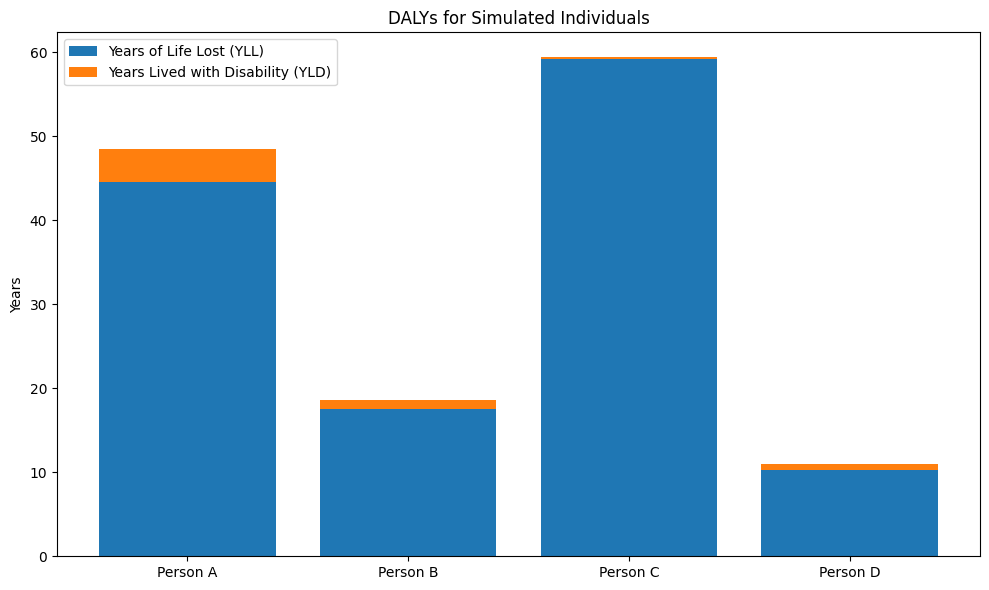

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(
    df_individual["Person"],
    df_individual["YLL"],
    label="Years of Life Lost (YLL)"
)

ax.bar(
    df_individual["Person"],
    df_individual["YLD"],
    bottom=df_individual["YLL"],
    label="Years Lived with Disability (YLD)"
)

ax.set_ylabel("Years")
ax.set_title("DALYs for Simulated Individuals")
ax.legend()

plt.tight_layout()
plt.show()


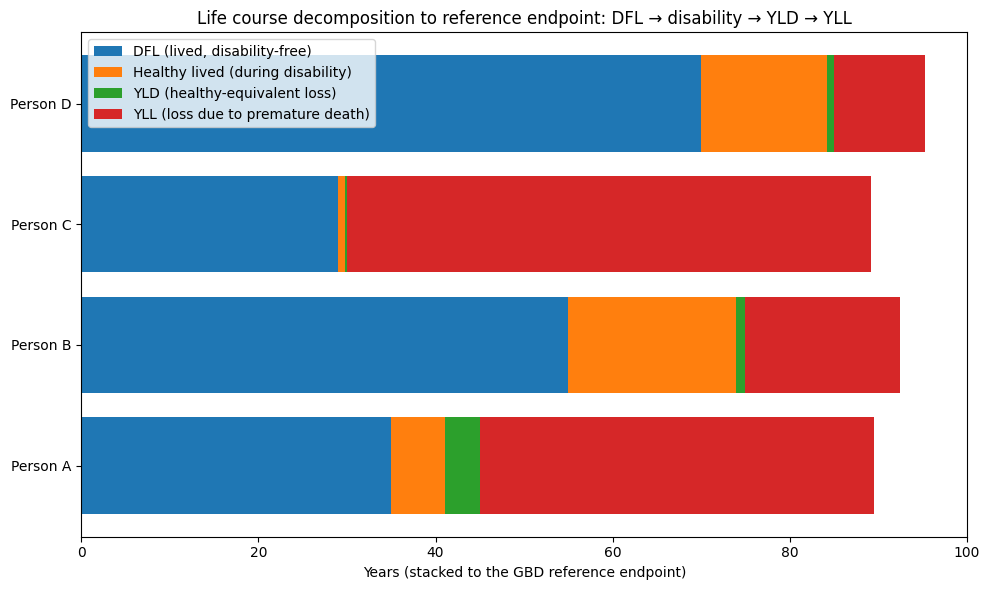

,Person,Reference endpoint age,DFL (years lived disability-free),Healthy lived (during disability),YLD (healthy years lost),YLL (years of life lost)
0,Person A,89.5,35,6.04,3.96,44.5
1,Person B,92.5,55,18.92,1.08,17.5
2,Person C,89.2,29,0.81,0.19,59.2
3,Person D,95.3,70,14.26,0.74,10.3


In [ ]:


# Example people structure (adjust to your actual list)
people = [
    {"id": "Person A", "age_at_death": 45, "years_with_condition": 10, "dw": get_dw("Moderate major depressive disorder")},
    {"id": "Person B", "age_at_death": 75, "years_with_condition": 20, "dw": get_dw("Moderate low back pain with leg pain")},
    {"id": "Person C", "age_at_death": 30, "years_with_condition":  1, "dw": get_dw("Vitamin A deficiency, with blindness")},
    {"id": "Person D", "age_at_death": 85, "years_with_condition": 15, "dw": get_dw("Uncomplicated diabetes mellitus type 2")},
]

rows = []
for p in people:
    age = p["age_at_death"]
    t = p["years_with_condition"]
    dw = p["dw"]

    # Simple assumption for teaching: condition starts t years before death
    dfl_years = max(age - t, 0)                 # years lived disability-free
    lived_with_disability_healthy = t * (1 - dw)
    yld = t * dw

    # YLL from the reference life table (remaining LE at age of death)
    yll = get_life_expectancy(age)

    reference_endpoint = age + yll

    rows.append({
        "Person": p["id"],
        "DFL (years lived disability-free)": dfl_years,
        "Healthy lived (during disability)": lived_with_disability_healthy,
        "YLD (healthy years lost)": yld,
        "YLL (years of life lost)": yll,
        "Reference endpoint age": reference_endpoint,
    })

df = pd.DataFrame(rows)

# ---- Plot (horizontal stacked bars read better) ----
fig, ax = plt.subplots(figsize=(10, 6))

y = np.arange(len(df))

left = np.zeros(len(df))
ax.barh(y, df["DFL (years lived disability-free)"], left=left, label="DFL (lived, disability-free)")
left += df["DFL (years lived disability-free)"]

ax.barh(y, df["Healthy lived (during disability)"], left=left, label="Healthy lived (during disability)")
left += df["Healthy lived (during disability)"]

ax.barh(y, df["YLD (healthy years lost)"], left=left, label="YLD (healthy-equivalent loss)")
left += df["YLD (healthy years lost)"]

ax.barh(y, df["YLL (years of life lost)"], left=left, label="YLL (loss due to premature death)")

ax.set_yticks(y)
ax.set_yticklabels(df["Person"])
ax.set_xlabel("Years (stacked to the GBD reference endpoint)")
ax.set_title("Life course decomposition to reference endpoint: DFL → disability → YLD → YLL")
ax.legend()

plt.tight_layout()
plt.show()

display(df[[
    "Person",
    "Reference endpoint age",
    "DFL (years lived disability-free)",
    "Healthy lived (during disability)",
    "YLD (healthy years lost)",
    "YLL (years of life lost)",
]].round(2))


## 4. Disability weights: what they are, and how they are elicited

A disability weight is not measured in a laboratory. It is derived from judgements about the severity of a health state.

### 4.1 How GBD elicits disability weights

The Global Burden of Disease (GBD) study primarily uses **paired comparisons** from large surveys. Respondents are shown two short descriptions of health states and asked which person is healthier. These ordinal judgements are modelled statistically and then anchored to produce disability weights on a 0–1 scale.

### 4.2 Other elicitation methods (and why they differ)

Different elicitation methods often produce systematically different values for the same health state.

- **Visual analogue scale (VAS):** respondents place a health state on a line (for example 0 = death, 100 = full health). This is simple, but it is sensitive to anchoring and does not enforce an explicit trade-off.
- **Time trade-off (TTO):** respondents trade length of life for quality of life (for example, 10 years in a health state is equivalent to *x* years in full health). This enforces a quantity–quality trade, but results depend on the time horizon and attitudes to death.
- **Standard gamble (SG):** respondents choose between a certain impaired health state and a gamble between full health and immediate death. This incorporates risk and is influenced by risk aversion.
- **Person trade-off (PTO):** respondents trade benefits across people (for example, curing 100 people of A versus curing *y* people of B). This resembles policy choices but mixes severity with moral judgements about distribution.

**Utilities and negative values:** in some QALY valuation systems, a health state can be valued as worse than death, producing negative utilities. Disability weights used in DALYs are bounded between 0 and 1; they do not take negative values.

### 4.3 Mini-exercise: VAS versus TTO for one health state

In this mini-exercise you will value one health state using two methods:

- VAS: you place the state on a 0–100 scale
- TTO: you indicate how many years in full health are equivalent to 10 years in the state

We convert to a disability weight using:
$$DW = 1 - u$$
where $u$ is the implied utility.

In [ ]:
# Choose one condition for the method comparison
condition_name = "Moderate depression"
gbd_dw = get_dw(condition_name)
gbd_u = 1 - gbd_dw

print(f"Condition: {condition_name}")
print(f"GBD disability weight (DW): {gbd_dw:.3f}  |  implied utility (1-DW): {gbd_u:.3f}")

In [ ]:
# Interactive comparison: VAS and TTO

vas = widgets.IntSlider(
    value=70, min=0, max=100, step=1,
    description="VAS (0–100):",
    continuous_update=False
)

tto = widgets.FloatSlider(
    value=8.0, min=0.0, max=10.0, step=0.1,
    description="TTO (years):",
    continuous_update=False
)

out = Output()

def update_display(change=None):
    with out:
        out.clear_output(wait=True)

        # VAS utility and DW
        u_vas = vas.value / 100
        dw_vas = 1 - u_vas

        # TTO utility and DW (10-year horizon)
        u_tto = tto.value / 10
        dw_tto = 1 - u_tto

        df = pd.DataFrame(
            {
                "Method": ["VAS", "TTO (10-year horizon)", "GBD (reference)"],
                "Utility (u)": [u_vas, u_tto, 1 - gbd_dw],
                "Disability weight (DW = 1-u)": [dw_vas, dw_tto, gbd_dw],
            }
        )

        display(df.style.format({"Utility (u)": "{:.3f}", "Disability weight (DW = 1-u)": "{:.3f}"}))

for w in [vas, tto]:
    w.observe(update_display, names="value")

update_display()
display(VBox([widgets.HTML("<b>Set values and compare:</b>"), vas, tto, out]))

### 4.4 Exercise: Set your own disability weights

Assign your own disability weights to the conditions below, then compare them to the GBD values.

Interpretation:
- 0.00 means full health
- 1.00 means equivalent to death

In [ ]:
# Display conditions for students to consider
print("DISABILITY WEIGHT EXERCISE")
print("=" * 80)
print("\nAssign a disability weight (0–1) to each condition below.")
print("0 = full health, 1 = equivalent to death")
print("-" * 80)

for i, c in enumerate(EXERCISE_CONDITIONS, 1):
    print(f"\n{i}. {c['name'].upper()}")
    print(f"   {c['description']}")

In [ ]:
# Interactive widget for setting disability weights

sliders = {}
slider_widgets = []

for c in EXERCISE_CONDITIONS:
    slider = FloatSlider(
        value=0.10, min=0.0, max=1.0, step=0.01,
        description="",
        continuous_update=False,
        readout_format=".2f",
        layout=widgets.Layout(width="320px")
    )
    sliders[c["name"]] = slider
    label = widgets.HTML(value=f"<b>{c['name']}</b>", layout=widgets.Layout(width="220px"))
    slider_widgets.append(HBox([label, slider]))

output = Output()

def compare_weights(change=None):
    with output:
        output.clear_output(wait=True)

        comparison_data = []
        for c in EXERCISE_CONDITIONS:
            your_weight = sliders[c["name"]].value
            gbd_weight = c["gbd_weight"]
            comparison_data.append(
                {
                    "Condition": c["name"],
                    "Your weight": your_weight,
                    "GBD weight": gbd_weight,
                    "Difference (you - GBD)": your_weight - gbd_weight,
                }
            )

        df = pd.DataFrame(comparison_data)

        # Simple plot without hard-coded colours
        fig, ax = plt.subplots(figsize=(12, 6))
        x = np.arange(len(df))
        width = 0.40

        ax.bar(x - width/2, df["Your weight"], width, label="Your weights")
        ax.bar(x + width/2, df["GBD weight"], width, label="GBD weights")

        ax.set_ylabel("Disability weight")
        ax.set_title("Your disability weights versus GBD 2019")
        ax.set_xticks(x)
        ax.set_xticklabels(df["Condition"], rotation=45, ha="right")
        ax.set_ylim(0, 1)
        ax.legend()
        plt.tight_layout()
        plt.show()

        display(
            df.style.format(
                {"Your weight": "{:.3f}", "GBD weight": "{:.3f}", "Difference (you - GBD)": "{:+.3f}"}
            )
        )

for slider in sliders.values():
    slider.observe(compare_weights, names="value")

compare_button = widgets.Button(description="Compare to GBD")
compare_button.on_click(compare_weights)

print("Adjust the sliders, then click 'Compare to GBD':")
display(VBox(slider_widgets + [compare_button, output]))

### 4.5 Discussion questions

1. Where did you differ most from GBD, and why?
2. Adaptation: people living with a condition may rate it as less severe. Whose values should count?
3. Cultural variation: might valuations differ across settings?
4. Some valuation systems allow negative utilities (worse than death). How should a policy system handle this conceptually?

## 5. How disability weights change rankings

We now use a hypothetical dataset to show how disability weights affect disease-burden rankings.

In [ ]:
# Hypothetical prevalence and mortality data (illustrative)
population_data = {
    "Mild anaemia": {"prevalence": 500_000, "deaths_by_age": {}},
    "Moderate hearing loss": {"prevalence": 300_000, "deaths_by_age": {}},
    "Moderate depression": {"prevalence": 150_000, "deaths_by_age": {45: 50, 55: 30, 65: 20}},
    "Severe low back pain": {"prevalence": 100_000, "deaths_by_age": {}},
    "Complete blindness": {"prevalence": 30_000, "deaths_by_age": {}},
    "Severe dementia": {"prevalence": 80_000, "deaths_by_age": {75: 2_000, 85: 5_000}},
    "Type 2 diabetes (controlled)": {"prevalence": 400_000, "deaths_by_age": {55: 100, 65: 500, 75: 1_000, 85: 500}},
    "Obesity (BMI ≥ 40)": {"prevalence": 200_000, "deaths_by_age": {45: 50, 55: 200, 65: 300, 75: 200}},
}

def calculate_burden_rankings(population_data: dict, disability_weights: dict, strict: bool = True) -> pd.DataFrame:
    """Return DALY rankings for a set of conditions.

    Parameters
    ----------
    population_data:
        Dictionary of condition -> {prevalence, deaths_by_age}.
    disability_weights:
        Dictionary of condition -> disability weight.
    strict:
        If True, raise an error when a disability weight is missing. If False, use NaN.
    """
    results = []

    for condition, data in population_data.items():
        if condition not in disability_weights:
            if strict:
                raise KeyError(f"Missing disability weight for condition: {condition!r}")
            dw = np.nan
        else:
            dw = disability_weights[condition]

        yll = 0.0
        if data["deaths_by_age"]:
            yll, _ = calculate_yll(data["deaths_by_age"])

        yld = calculate_yld(data["prevalence"], dw) if pd.notna(dw) else np.nan
        dalys = yll + yld if pd.notna(yld) else np.nan

        results.append({"Condition": condition, "DW": dw, "YLL": yll, "YLD": yld, "DALYs": dalys})

    df = pd.DataFrame(results).sort_values("DALYs", ascending=False)
    df["Rank"] = range(1, len(df) + 1)
    return df[["Rank", "Condition", "DW", "YLL", "YLD", "DALYs"]]

In [ ]:
# Rankings using GBD weights (for these named conditions)
gbd_weights = {c["name"]: c["gbd_weight"] for c in EXERCISE_CONDITIONS}
gbd_rankings = calculate_burden_rankings(population_data, gbd_weights, strict=True)

print("Disease burden rankings using GBD disability weights")
print("=" * 80)
display(gbd_rankings.style.format({"DW": "{:.3f}", "YLL": "{:,.0f}", "YLD": "{:,.0f}", "DALYs": "{:,.0f}"}))

In [ ]:
# Rankings using your weights (from the sliders)
your_weights = {name: slider.value for name, slider in sliders.items()}
your_rankings = calculate_burden_rankings(population_data, your_weights, strict=True)

print("Disease burden rankings using your disability weights")
print("=" * 80)
display(your_rankings.style.format({"DW": "{:.3f}", "YLL": "{:,.0f}", "YLD": "{:,.0f}", "DALYs": "{:,.0f}"}))

## 6. DALYs versus QALYs

| Aspect | DALY | QALY |
|--------|------|------|
| Direction | Higher = more burden | Higher = more health gain |
| Typical use | Population burden estimation | Cost-effectiveness analysis |
| Common users | GBD, WHO | NICE and health technology assessment |

A useful identity is:

$$\text{QALYs} = \text{years lived} \times u$$

where $u$ is a health-related utility (often on a 0–1 scale).

In [ ]:
# Example: Cataract surgery programme (illustrative)

qalys, utility_gain = calculate_qalys_gained(
    intervention_effect=0.95,
    population=10_000,
    duration=15,
    dw_before=get_dw("Complete blindness"),
    dw_after=0.003  # illustrative post-treatment weight
)

print("Cataract surgery programme (illustrative)")
print("=" * 55)
print("Population: 10,000 people")
print("Success rate: 95%")
print("Duration of benefit: 15 years")
print()
print(f"Utility gain per person: {utility_gain:.3f}")
print(f"Total QALYs gained: {qalys:,.0f}")

programme_cost = 10_000_000
print()
print(f"If programme cost is £10,000,000: £{programme_cost / qalys:,.0f} per QALY (simple ratio)")

## 7. Limitations and critique

### 7.1 The disability rights critique

A common critique is that QALYs (and sometimes DALY-based reasoning) can disadvantage people with disability if the model treats their lives as systematically producing fewer quality-adjusted years.

### 7.2 Illustration: the discrimination problem

In [ ]:
print("The QALY discrimination illustration")
print("=" * 60)
print("Scenario: A life-saving treatment adds 10 years of life.")
print()

qalys_nondisabled = 10 * 1.0
print(f"Patient A (utility 1.0): 10 years × 1.0 = {qalys_nondisabled:.1f} QALYs")

dw_paraplegia = 0.133  # illustrative
u_paraplegia = 1 - dw_paraplegia
qalys_disabled = 10 * u_paraplegia
print(f"Patient B (paraplegia, utility {u_paraplegia:.3f}): 10 years × {u_paraplegia:.3f} = {qalys_disabled:.1f} QALYs")
print()
print(f"Under this framework, Patient A yields {qalys_nondisabled / qalys_disabled:.1%} of Patient B's QALYs for the same life extension.")

## 8. Exercises

### Exercise 8.1: Calculate DALYs for iron deficiency anaemia

Data (hypothetical population):
- Mild anaemia: 800,000 (DW = 0.004)
- Moderate anaemia: 150,000 (DW = 0.052)
- Severe anaemia: 20,000 (DW = 0.149)
- Deaths: 500 at age 75, and 1,000 at age 85

Your output should include:
- YLD (sum across severities)
- YLL (from deaths)
- Total DALYs

In [ ]:
# YOUR CODE HERE

# Hint:
# 1. Compute YLD for each severity using calculate_yld(prevalence, dw)
# 2. Compute YLL using calculate_yll({75: 500, 85: 1000})
# 3. Add them to obtain total DALYs


### Exercise 8.2: Reflection questions

1. The GBD weight for obesity (0.086) is lower than for depression (0.145). Do you agree?
2. Some early DALY formulations included age-weighting (valuing some ages more than others). What are the arguments for and against?
3. How might you measure the burden of poor diet without relying only on disease categories?

---

## References

- GBD 2019 Diseases and Injuries Collaborators. (2020). *The Lancet*.
- Salomon JA et al. (2015). Disability weights for the Global Burden of Disease Study. *Lancet Global Health*.
- Nord E. (2015). Limitations of the QALY. *Cambridge Quarterly of Healthcare Ethics*.